## Sam Arnts
## Hanyang Zhang
## DSCC 265
## Kaggle Competition

In [56]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy import sparse

In [57]:
train_data = pd.read_csv("congressional_tweet_training_data.csv")
train_data.head()

,favorite_count,full_text,hashtags,retweet_count,year,party_id
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D


In [58]:
train_data['full_text'] = train_data['full_text'].apply(str)    

In [59]:
text = train_data['full_text']
hashtags = train_data['hashtags']

In [60]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

In [61]:
def clean(text):
    clean_text = []
    sentiment = []
    for tweet in text:
        ##getting rid of links, charcters, weird x/ phrases
        tweet = re.sub(r'http\S+', '', tweet)
        tweet = re.sub("[^a-zA-Z]", " ", tweet)
        tweet = re.sub('xe2', " ", tweet)
        
        tweet = tweet.lower()
        
        #replacting amp with and (shows up as amp in text instead of &)
        tweet = tweet.replace("amp", "and")
        
        #sentiment analysis
        polarity = sia.polarity_scores(tweet)
        
        sentiment.append(polarity['pos'] - polarity['neg']) 
            
        #tokenizing
        tweet = nltk.word_tokenize(tweet)
        
        #getting rid of 'b'
        tweet.pop(0)
        
        #removing stop words and getting rid of weird x-phrases  and 'b in data set
        tweet = [word for word in tweet if not word in (tuple(stop_words))]
        
        #getting rid of weird /xe2 phrase
        tweet = [word for word in tweet if not (word[0] =='x')]
        
        
        #lemmatizing
        tweet = [lemmatizer.lemmatize(word) for word in tweet]
        
        
        #joining back together
        tweet = " ".join(tweet)
        
        
        clean_text.append(tweet)
    return clean_text, sentiment

In [62]:
#cleaning the text, getting the tweet sentiment
clean_text, tweet_sentiment = clean(text)

In [63]:
train_data['clean_text'] = clean_text
train_data.head()

,favorite_count,full_text,hashtags,retweet_count,year,party_id,clean_text
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R,rt kusinews one longtime viewer congressman da...
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R,today urging cdcgov immediately launch phone h...
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R,tomorrow mo senior graduate calvary lutheran f...
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R,congrats teamusa canton native jgreenway winni...
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D,pleased support amergateways june fiesta honor...


In [64]:
#sorting the cleaned text into republican and democratic tweets
repub_text = []
dem_text = []
repub_hashtag = []
dem_hashtag = []

for index, row in train_data.iterrows():
    if row["party_id"] == "R":
        repub_text.append(row["clean_text"])
        repub_hashtag.append(row["hashtags"])
    else:
        dem_text.append(row["clean_text"])
        dem_hashtag.append(row["hashtags"])

In [68]:
def party_vectorize(text, n):
    
    #vectorizing the text
    vec = CountVectorizer(max_features = 150000).fit(text)
    bag_of_words = vec.transform(text)
    
    #summing up the usage of the words
    sum_words = bag_of_words.sum(axis=0) 
    
    #getting the frequency of the words
    freq = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    
    #sorting out the n most used words in the texts
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    freq_dict = dict(freq[:n])
       

    return freq_dict

In [66]:
def party_score(dem_dict, repub_dict, text, exclusive, less, most):
    
    #power 20
    dem_power = {k: dem_dict[k] for k in list(dem_dict)[:20]}
    repub_power = {k: repub_dict[k] for k in list(repub_dict)[:20]}
    
    #a dict with the top n used words
    dem_exclusive = {k: dem_dict[k] for k in list(dem_dict)[:exclusive]}
    repub_exclusive = {k: repub_dict[k] for k in list(repub_dict)[:exclusive]}
    
    #a dict with the top n used words (less words than exclusive)
    dem_less = {k: dem_dict[k] for k in list(dem_dict)[:less]}
    repub_less = {k: repub_dict[k] for k in list(repub_dict)[:less]}
    
    #a dict with the top n used words (even less words than less (most exclusive))
    dem_most = {k: dem_dict[k] for k in list(dem_dict)[:most]}
    repub_most = {k: repub_dict[k] for k in list(repub_dict)[:most]}
    
    dem = []
    repub = []
    for tweet in text:
        repub_score = 0
        dem_score = 0
        words = tweet.split()
        
        
        #assigning scores to words based on whether there in a party dict,
        #and assigning more points if theyre not in the other parties dicts
        for word in words:
            if word in dem_dict:
                if word in dem_power and (word not in repub_power):
                    dem_score += 50000
                if word not in repub_exclusive:
                    dem_score += 100000 * dem_dict.get(word)
                if word not in repub_less:
                    dem_score += 10000 * dem_dict.get(word)
                if word not in repub_most:
                    dem_score += 1000 * dem_dict.get(word)
                else:
                    dem_score += dem_dict.get(word)
                    
            if word in repub_dict:
                if word in repub_power and (word not in dem_power):
                    repub_score += 50000
                if word not in dem_exclusive:
                    repub_score += 100000 * repub_dict.get(word)
                if word not in dem_less:
                    repub_score += 10000 * repub_dict.get(word)
                if word not in dem_most:
                    repub_score += 1000 * repub_dict.get(word)
                else:
                    repub_score += repub_dict.get(word)
                    
        dem.append(dem_score)
        repub.append(repub_score)
   
        
    
    return dem, repub
        

In [69]:
##creating dictionaries of the most used words for each of the parties
dem_dict = party_vectorize(dem_text, 1000000)
repub_dict = party_vectorize(repub_text, 1000000)
dem_hash_dict = party_vectorize(dem_hashtag, len(hashtags))
repub_hash_dict = party_vectorize(repub_hashtag, len(hashtags))

In [70]:
#getting the dem score and repub score for every tweet
dem_score, repub_score = party_score(dem_dict, repub_dict, clean_text, 25000, 5000, 2500)
dem_hash_score, repub_hash_score  = party_score(dem_hash_dict, repub_hash_dict, hashtags, 100000, 50000, 25000)

In [71]:
d = {"dem_score" : dem_score, "repub_score" : repub_score, "dem_hash_score" : dem_hash_score,
    "repub_hash_score" : repub_hash_score, "sentiment" : tweet_sentiment}

X_train = pd.DataFrame(d)
X_train

,dem_score,repub_score,dem_hash_score,repub_hash_score,sentiment
0,1263166,8449911,0,0,0.151
1,657604,488026,0,0,0.000
2,1575406,9421653,0,0,0.000
3,380216,866420,0,0,0.452
4,5941684,735920,0,0,0.322
...,...,...,...,...,...
592798,384847,277168,33,21,0.224
592799,125909,4673686,0,0,0.307
592800,8090328,169094,0,0,-0.094
592801,1122958,1113225,244,410,0.080


In [72]:
#scaling
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_train)
X_scaled = pd.DataFrame(X_scaled, columns = ['dem_score', 'repub_score', 'dem_hash_score', 'repub_hash_score', 'sentiment'])
X_scaled.head()

,dem_score,repub_score,dem_hash_score,repub_hash_score,sentiment
0,0.000879,0.004934,0.0,0.0,0.5755
1,0.000457,0.000285,0.0,0.0,0.5000
2,0.001096,0.005502,0.0,0.0,0.5000
3,0.000264,0.000506,0.0,0.0,0.7260
4,0.004132,0.000430,0.0,0.0,0.6610


In [73]:
y = train_data["party_id"]

In [74]:
#fitting our random forest classification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .10, random_state =265)
model = RandomForestClassifier(max_depth = 20, random_state = 0)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
rf_accuracy = accuracy_score(prediction, y_test)
rf_accuracy

0.8612877650511969

## Predicting the Test Data

In [75]:
test_data = pd.read_csv("congressional_tweet_test_data.csv")

In [76]:
test_hashtags = test_data['hashtags']
test_text = test_data['full_text']

In [77]:
#cleaning the test text in the same way
test_clean_text, test_tweet_sentiment = clean(test_text)

In [101]:
#scoring the text based on the dictionaries created above
test_dem_score, test_repub_score = party_score(dem_dict, repub_dict, test_clean_text, 25000, 5000, 2500)
test_dem_hash_score, test_repub_hash_score = party_score(dem_hash_dict, repub_hash_dict, test_hashtags, 100000, 50000, 25000)

In [102]:
d_test = {"test_dem_score" : test_dem_score, "test_repub_score" : test_repub_score, "test_dem_hash_score" : test_dem_hash_score,
    "test_repub_hash_score" : test_repub_hash_score, "sentiment" : test_tweet_sentiment}

X_test = pd.DataFrame(d_test)
X_test = min_max_scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns = ['dem_score', 'repub_score', 'dem_hash_score', 'repub_hash_score', 'sentiment'])
X_test.head()

,dem_score,repub_score,dem_hash_score,repub_hash_score,sentiment
0,0.000234,0.000127,0.0,0.0,0.6120
1,0.006567,0.000044,0.0,0.0,0.5305
2,0.008248,0.000907,0.0,0.0,0.4310
3,0.000995,0.048622,0.0,0.0,0.6310
4,0.000404,0.004345,0.0,0.0,0.6440


In [103]:
#making the prediction
test_prediction = model.predict(X_test)

In [104]:
#results11 = pd.DataFrame({'party' : test_prediction})
#results11 = pd.DataFrame({'Id' : list(results11.index.values), 'party' : test_prediction})
#results11.to_csv('results_11.csv', header=True, index=False)

## Data Visualization

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

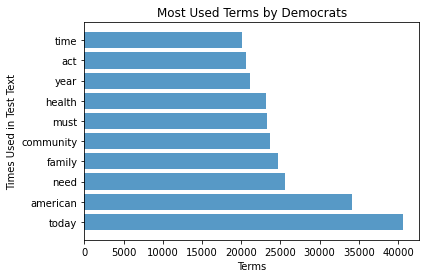

In [45]:
first_ten_dems = {k: dem_dict[k] for k in list(dem_dict)[:10]}

dem_keys= []
dem_vals = []
for key in first_ten_dems.keys():
    dem_keys.append(key)
    dem_vals.append(first_ten_dems.get(key))

plt.barh(dem_keys, dem_vals, align='center', alpha = 0.75)
plt.xlabel("Terms")
plt.ylabel("Times Used in Test Text")
plt.title("Most Used Terms by Democrats")
plt.savefig("dem_words.png", dpi=300)

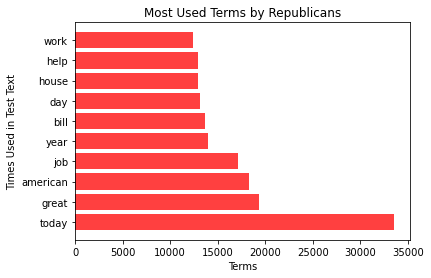

In [46]:
first_ten_repub = {k: repub_dict[k] for k in list(repub_dict)[:10]}

repub_keys= []
repub_vals = []
for key in first_ten_repub.keys():
    repub_keys.append(key)
    repub_vals.append(first_ten_repub.get(key))

plt.barh(repub_keys, repub_vals, align='center', alpha = 0.75, color='red')
plt.xlabel("Terms")
plt.ylabel("Times Used in Test Text")
plt.title("Most Used Terms by Republicans")
plt.savefig("repub_words.png", dpi=300)

In [50]:
import random

clean_text_mini = []
mini_id = []
for i in range(500):
    random_index = random.randrange(len(clean_text))
    clean_text_mini.append(clean_text[random_index])
    mini_id.append(y[random_index])


positive = []
negative = []
for tweet in clean_text_mini:
    
    polarity = sia.polarity_scores(tweet)
    positive.append(polarity['pos'])
    negative.append(polarity['neg'])

In [51]:
#changign R and D to 0 and 1
for i in range(len(mini_id)):
    if mini_id[i] == 'R':
        mini_id[i] = 0
    if mini_id[i] == 'D':
        mini_id[i] = 1

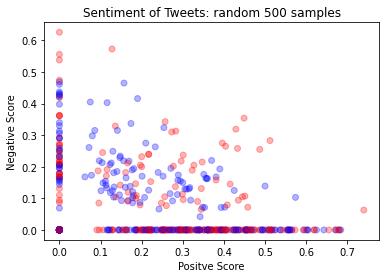

In [52]:
colors = ['red', 'blue']

plt.scatter(positive, negative, c=mini_id, cmap=mpl.colors.ListedColormap(colors), alpha = 0.3)
plt.title("Sentiment of Tweets: random 500 samples")
plt.xlabel("Positve Score")
plt.ylabel("Negative Score")
plt.savefig("sentiment.png", dpi=300)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .10, random_state =265)
model2 = GaussianNB()
model2.fit(X_train, y_train)
gauss_predict = model2.predict(X_test)
gauss_accuracy = accuracy_score(gauss_predict, y_test)

In [112]:
model3 = ComplementNB()
model3.fit(X_train, y_train)
compl_predict = model3.predict(X_test)
complement_accuracy = accuracy_score(compl_predict, y_test)

In [113]:
model4 = LogisticRegressionCV(cv=5, random_state=265, max_iter = 1000, n_jobs=-1)
model4.fit(X_train, y_train)
log_predict = model4.predict(X_test)
log_accuracy = accuracy_score(log_predict, y_test)

In [114]:
model5 = AdaBoostClassifier(n_estimators = 250)
model5.fit(X_train, y_train)
ada_predict = model5.predict(X_test)
ada_accuracy = accuracy_score(ada_predict, y_test)
ada_accuracy                            

0.8302491523422344

In [115]:
models = ["Logistic", "Gaussian", "Complement", "RandomForest", "ADABoost"]    
values = [log_accuracy, gauss_accuracy, complement_accuracy, rf_accuracy, ada_accuracy]

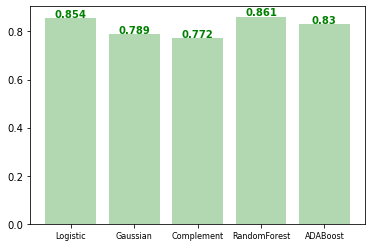

In [116]:
fig, ax = plt.subplots()

bars = ax.bar(
        x = models,
        height = values,
        color='green',
        alpha = 0.3)

for bar in bars:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.005,
      round(bar.get_height(), 3),
      horizontalalignment='center',
      color='green',
      weight='bold'
  )

plt.tick_params(axis='x', labelsize=8)
plt.savefig("model_testing.png", dpi=300)